# Machine Learning for Wind Power Forecasting

This notebook implements multiple models for wind power forecasting. The first uses a one-step model based on a Random Forest (RF) regressor that predicts the wind power at the next time step based on a past hour of power outputs. The second uses a multi-step (recursive autoregressive) model to predict an hour ahead in 10min increments based on a past hour of power outputs. The results show that high autocorrelation of wind power results in an autoregressive model that performs slightly better with a linear regressor than it does with RF.  

In [4]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from albatross.analysis import plot_windrose, boxplot
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import numpy as np

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster, grid_search_forecaster

In [455]:
cmap = mpl.colormaps['tab10']

## Data

The data consists of two years (2019-2020) of Wind Turbine data from the Kelmarsh Wind Farm in the UK.

Plumley, Charlie. Kelmarsh Wind Farm Data. Zenodo, 1 Feb. 2022. Zenodo, https://doi.org/10.5281/zenodo.5841834.


In [6]:
# TODO: Use full farm data in analysis (currently using one turbine).

# DATA_DIRS = ['../data/Kelmarsh_SCADA_2019/', '../data/Kelmarsh/SCADA_2020']

# FNAMES = [
#     "Turbine_Data_Kelmarsh_1_2020-01-01_-_2021-01-01_228.csv",
    # "Turbine_Data_Kelmarsh_2_2020-01-01_-_2021-01-01_229.csv",
    # "Turbine_Data_Kelmarsh_3_2020-01-01_-_2021-01-01_230.csv",
    # "Turbine_Data_Kelmarsh_4_2020-01-01_-_2021-01-01_231.csv",
    # "Turbine_Data_Kelmarsh_5_2020-01-01_-_2021-01-01_232.csv",
    # "Turbine_Data_Kelmarsh_6_2020-01-01_-_2021-01-01_233.csv",
# ]

# turbines = []

# for i, _ in enumerate(FNAMES):
#     fname = DATA_DIRS[0] + FNAMES[i]
#     print(f"Loading data: {FNAMES[i]}")
#     wt = pd.read_csv(fname, header=9)
#     turbines.append(wt)

wt_2019 = pd.read_csv("../data/Kelmarsh_SCADA_2019/Turbine_Data_Kelmarsh_1_2019-01-01_-_2020-01-01_228.csv", header=9)
wt_2020 = pd.read_csv("../data/Kelmarsh_SCADA_2020/Turbine_Data_Kelmarsh_1_2020-01-01_-_2021-01-01_228.csv", header=9)

wt_raw = pd.concat([wt_2019, wt_2020])

In [7]:
wt_raw.columns[wt_raw.columns.str.contains("power")]

Index(['Potential power default PC (kW)', 'Potential power learned PC (kW)',
       'Potential power reference turbines (kW)',
       'Cascading potential power (kW)',
       'Cascading potential power for performance (kW)',
       'Potential power met mast anemometer (kW)',
       'Potential power primary reference turbines (kW)',
       'Potential power secondary reference turbines (kW)',
       'Potential power estimated (kW)', 'Potential power MPC (kW)',
       'Potential power met mast anemometer MPC (kW)', 'Reactive power (kvar)',
       'Reactive power, Max (kvar)', 'Reactive power, Min (kvar)',
       'Reactive power, Standard deviation (kvar)', 'Apparent power (kVA)',
       'Apparent power, Max (kVA)', 'Apparent power, Min (kVA)',
       'Apparent power, StdDev (kVA)'],
      dtype='object')

In [8]:
wt = wt_raw.loc[:, ["# Date and time", "Power (kW)", "Wind direction (°)", "Wind speed (m/s)"]]
wt = wt.rename(columns={"# Date and time": "Date", "Power (kW)": "Power", "Wind direction (°)": "Wind direction", "Wind speed (m/s)": "Wind speed"})
wt["Date"] = pd.to_datetime(wt["Date"].astype("datetime64"))
wt = wt.set_index("Date")
wt = wt.asfreq("10min")

wt["Power"].bfill(inplace=True)
wt["Wind direction"].bfill(inplace=True)
wt["Wind speed"].bfill(inplace=True)
# wt["Power"] = wt["Power"].transform(lambda p: max(p, 0))
wt = wt.sort_index()

wt.head()

,Power,Wind direction,Wind speed
Date,,,
2019-01-01 00:00:00,191.814896,284.644043,4.454060
2019-01-01 00:10:00,189.524963,288.776154,4.331436
2019-01-01 00:20:00,381.144653,292.093292,5.447210
2019-01-01 00:30:00,422.717590,294.645264,5.472900
2019-01-01 00:40:00,307.518646,299.022400,5.601278


In [9]:
# check timeseries format
(wt.index == pd.date_range(start=wt.index.min(),
                             end=wt.index.max(),
                             freq=wt.index.freq)).all()

True

In [10]:
wt.describe()

,Power,Wind direction,Wind speed
count,105264.000000,105264.000000,105264.000000
mean,658.230309,200.768777,6.298800
std,645.270553,90.442918,2.883361
min,-17.846463,0.007310,0.134232
25%,125.766387,143.144123,4.226321
50%,431.540100,218.771682,6.025231
75%,1035.737753,261.830924,7.927109
max,2081.028912,359.996088,22.419562


In [11]:
# ensure no null values
len(wt[wt["Power"].isnull()]) == 0

True

In [462]:
speed = wt.loc[:, "Wind speed"]
direction = wt.loc[:, "Wind direction"]
active_power = wt.loc[:, "Power"]

The wind speed distribution represents a typical right-skewed distribution, where we see the highest counts around 5-6 m/s

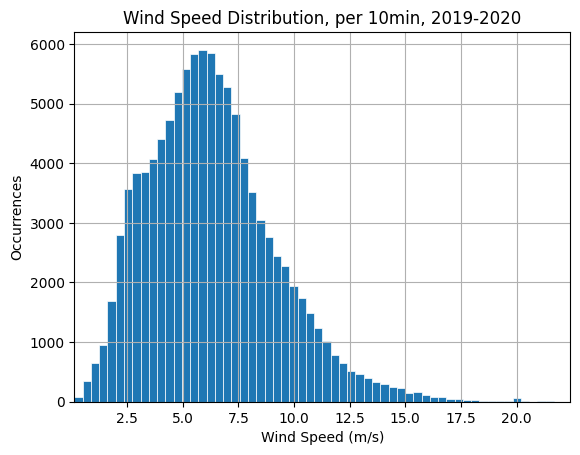

In [463]:
fig, ax = plt.subplots()

ax.set_title("Wind Speed Distribution, per 10min, 2019-2020")
ax.set_xlabel("Wind Speed (m/s)")
ax.set_ylabel("Occurrences")
ax.set_xmargin(0)
ax.hist(speed, 60, linewidth=0.5, edgecolor="white")
ax.grid(True)

#fig.savefig("ws_distribution.png")

A wind rose is a useful visualization that simultaneously characterizes wind speed and wind direction. The magnitude of a spoke represents the percentage of time in that direction. In this one we see that the predominant wind direction is SW.

<WindroseAxes:>

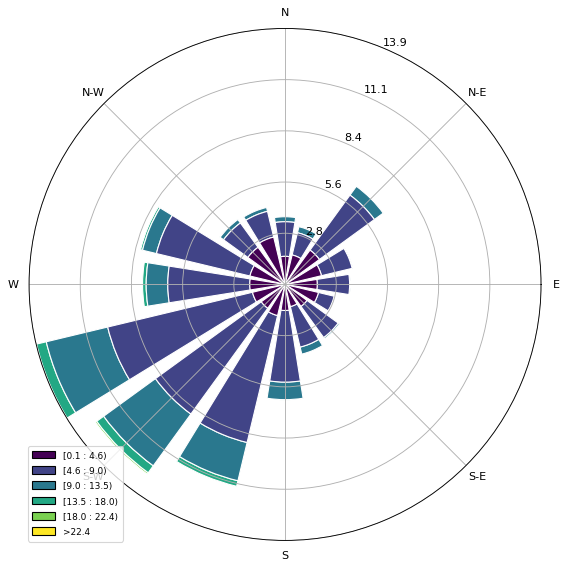

In [464]:
plot_windrose(wt, speed="Wind speed", direction="Wind direction")

We can also look at wind speed vs power output. We see that there is a strong correlation between the two, which is expected. There's an exception here in the middle of the day, where the power drops to zero. It looks like the turbine cut-in speed is around 2 m/s, meaning that it will shut off below that wind speed.

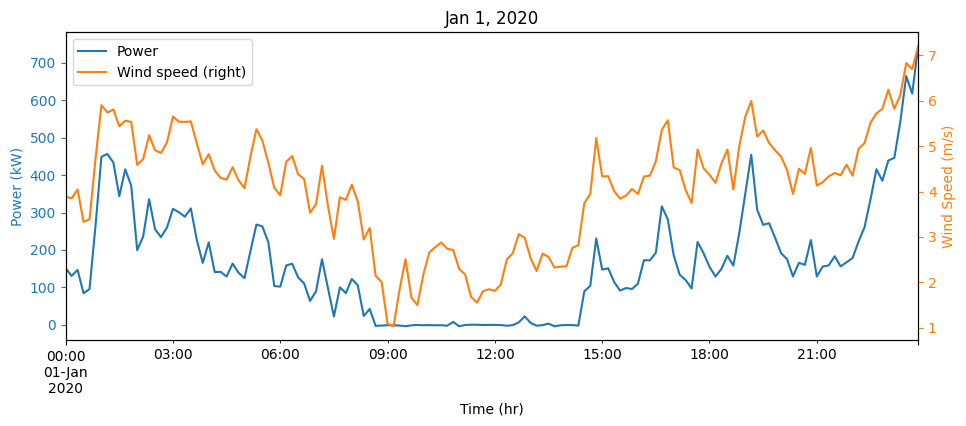

In [465]:
wt_1day = wt.loc[(wt.index >= "2020-01-01") & (wt.index < "2020-01-02")]

fig, ax1 = plt.subplots(figsize=(11, 4))

wt_1day[["Power", "Wind speed"]].plot(secondary_y="Wind speed", ax=ax1)

ax1.set_title("Jan 1, 2020")
ax1.set_ylabel("Power (kW)")
ax1.set_xmargin(0)
ax1.set_xlabel("Time (hr)")
ax1.tick_params(axis='y', colors=cmap.colors[0])
ax1.yaxis.label.set_color(cmap.colors[0])
ax1.right_ax.set_ylabel("Wind Speed (m/s)")
ax1.right_ax.yaxis.label.set_color(cmap.colors[1])
ax1.right_ax.tick_params(axis='y', colors=cmap.colors[1])

#fig.savefig("p_ws.png")

If we plot all of the observations of wind speed vs power, we get a representation of the turbine's power curve. As we saw before, it appears that the cut-in speed is around 2 m/s, and the rated power is around 2000 kW, or 2 MW. The turbine controls will prevent it from attempting to produce beyond that point, so the curve levels off at that power. Finally, we see that the cut-out speed is around 20 m/s, where the turbine will shut down to prevent damage from high winds.

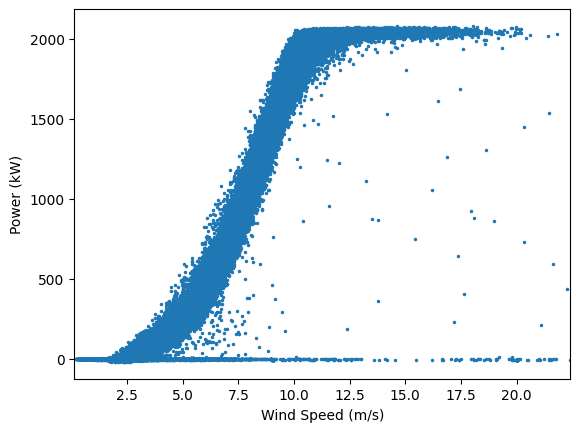

In [466]:
fig, ax = plt.subplots()
ax.plot(speed, active_power, "o", markersize=1.5)
ax.set_xlabel("Wind Speed (m/s)")
ax.set_ylabel("Power (kW)")
ax.set_xmargin(0)

# fig.savefig("power_curve.png")

In [467]:
# wt_yr = wt[:, ["Direction", "Wind speed", "Power"]]
# fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
# ax.plot_trisurf(direction, speed, active_power)

This information is useful, but in order to form a forecasting model, we need to determine a feature set that incorporates an intuition about the past so that we can predict the future. One way to look at this is through autocorrelation: how does past power correlate with current power? We can explore this by calculating the correlation coefficients of current power with its past values, also called "lags". We see from the plot that current power is highly correlated with past power, up to a certain point. With this knowledge, we can attempt to build a model that uses these lags themselves as features!

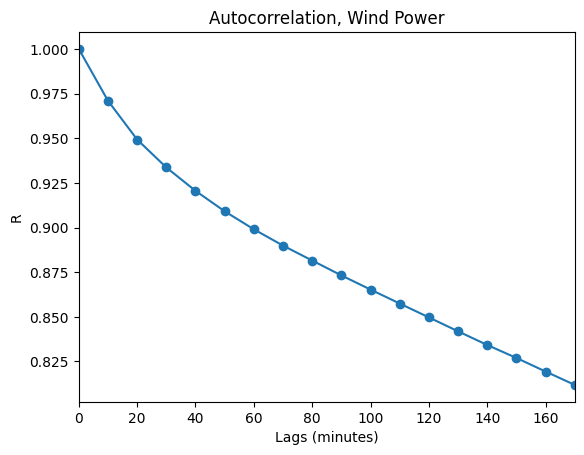

In [468]:
period = wt.index.to_series().asfreq("10T")[18:]

LAG = 18

X = np.zeros((len(period), LAG))
y = np.zeros(len(period))

current = LAG

for i, row in enumerate(X):
    X[i, :LAG] = data[current-LAG:current]
    y[i] = data[current]
    current += 1

columns = [f"p_{18-i}0" for i in range(LAG)]

X = pd.DataFrame(X, index=period, columns=columns)
y = pd.Series(y, index=period)

X.head(2)


fig, ax = plt.subplots()

results = []

for i in range(LAG):
    corr = np.corrcoef(X[f"p_180"], X[f"p_{18-i}0"])
    results.append(corr[0, 1])
    
results

x = np.arange(0, 180, 10)
ax.scatter(x, results)
ax.plot(x, results)
ax.set_xlabel("Lags (minutes)")
ax.set_ylabel("R")
ax.set_title("Autocorrelation, Wind Power")
ax.set_xmargin(0)

# fig.savefig("auto_corr.png")

## First approach: single step model

This model trains a Random Forest regressor using lags as features. 

Building the feature matrix consists of the following steps:
1. Create a new timeseries with frequency of an hour, starting at 1:00 (the first hour must be used for lag data)
2. For each hour, set lags as defined by the `LAG` variable, which represents the number of 10min increments to include as features
3. For each hour, set the output `y` as the power output at the "current" time step

The result is a feature matrix that, for each hour, represents 1hr of past power values.

In [469]:
data = wt["Power"]

data.head(13)

Date
2019-01-01 00:00:00    191.814896
2019-01-01 00:10:00    189.524963
2019-01-01 00:20:00    381.144653
2019-01-01 00:30:00    422.717590
2019-01-01 00:40:00    307.518646
2019-01-01 00:50:00    100.532738
2019-01-01 01:00:00     51.613712
2019-01-01 01:10:00    152.640259
2019-01-01 01:20:00    188.583817
2019-01-01 01:30:00    154.423843
2019-01-01 01:40:00    262.382996
2019-01-01 01:50:00    347.363495
2019-01-01 02:00:00    394.709747
Freq: 10T, Name: Power, dtype: float64

In [470]:
period = wt.index.to_series().asfreq("1H")[1:]

LAG = 6

X = np.zeros((len(period), LAG))
y = np.zeros(len(period))

current = LAG

for i, row in enumerate(X):
    X[i, :LAG] = data[current-LAG:current]
    y[i] = data[current]
    current += LAG

columns = [f"p_{6-i}0" for i in range(LAG)]

X = pd.DataFrame(X, index=period, columns=columns)
y = pd.Series(y, index=period)

X.head(5)

,p_60,p_50,p_40,p_30,p_20,p_10
Date,,,,,,
2019-01-01 01:00:00,191.814896,189.524963,381.144653,422.717590,307.518646,100.532738
2019-01-01 02:00:00,51.613712,152.640259,188.583817,154.423843,262.382996,347.363495
2019-01-01 03:00:00,394.709747,446.346191,442.942749,579.502258,525.571655,446.324860
2019-01-01 04:00:00,468.327240,755.153259,855.787842,883.324524,1053.337646,1441.237793
2019-01-01 05:00:00,1329.703735,1585.042236,1898.120728,1879.494629,1184.465332,895.802307


In [471]:
y

Date
2019-01-01 01:00:00      51.613712
2019-01-01 02:00:00     394.709747
2019-01-01 03:00:00     468.327240
2019-01-01 04:00:00    1329.703735
2019-01-01 05:00:00     618.034058
                          ...     
2020-12-31 19:00:00      -0.898414
2020-12-31 20:00:00      -1.136889
2020-12-31 21:00:00      -1.106311
2020-12-31 22:00:00      -1.390301
2020-12-31 23:00:00      -1.348688
Length: 17543, dtype: float64

In [472]:
# check that the lags are created properly
np.array_equal(X.iloc[0, :], data[:LAG])

True

Split the data into training and testing sets.

In [473]:
X_train = X[X.index < "2020-01-01"]
X_test = X[(X.index >= "2020-01-01")]
y_train = y[y.index < "2020-01-01"]
y_test = y[(X.index >= "2020-01-01")]

In [474]:
X_train

,p_60,p_50,p_40,p_30,p_20,p_10
Date,,,,,,
2019-01-01 01:00:00,191.814896,189.524963,381.144653,422.717590,307.518646,100.532738
2019-01-01 02:00:00,51.613712,152.640259,188.583817,154.423843,262.382996,347.363495
2019-01-01 03:00:00,394.709747,446.346191,442.942749,579.502258,525.571655,446.324860
2019-01-01 04:00:00,468.327240,755.153259,855.787842,883.324524,1053.337646,1441.237793
2019-01-01 05:00:00,1329.703735,1585.042236,1898.120728,1879.494629,1184.465332,895.802307
...,...,...,...,...,...,...
2019-12-31 19:00:00,422.413500,351.308083,361.224901,448.551263,400.217412,361.243307
2019-12-31 20:00:00,211.967521,190.288498,151.567813,212.682542,348.583901,347.499438
2019-12-31 21:00:00,221.433291,176.188798,282.139910,455.926382,228.359885,255.842170


In [475]:
X_test

,p_60,p_50,p_40,p_30,p_20,p_10
Date,,,,,,
2020-01-01 00:00:00,129.151435,121.942842,171.363560,232.957892,282.135746,193.669499
2020-01-01 01:00:00,150.984141,130.414782,146.401656,84.296224,94.994105,262.992229
2020-01-01 02:00:00,449.115810,456.427864,433.714243,343.683160,415.606102,371.579486
2020-01-01 03:00:00,199.209134,235.702883,335.663537,255.108857,234.261773,260.194224
2020-01-01 04:00:00,309.811697,300.722514,288.692892,310.927899,226.487825,165.236907
...,...,...,...,...,...,...
2020-12-31 19:00:00,-1.936605,-2.980131,-1.698131,-1.315078,-2.602413,-1.058998
2020-12-31 20:00:00,-0.898414,-1.724806,-0.690181,-1.285735,-1.892325,-1.327882
2020-12-31 21:00:00,-1.136889,-1.818702,-1.271864,-1.142224,-2.314323,-1.609036


In [476]:
# X_test.loc["2020-02-29"] # it's a leap year :^D

Train a Random Forest regressor using a training set consisting of 2019 data.

In [477]:
rf = RandomForestRegressor(n_estimators=500, oob_score=True, random_state=123)
rf

RandomForestRegressor(n_estimators=500, oob_score=True, random_state=123)

Calculate an out-of-bag (OOB) estimate, coefficient of determination ($R^2$), root mean squared error (RMSE) and mean absolute error (MAE).

In [478]:
rf.fit(X_train, y_train)

rf.oob_score_

0.9332268292762537

In [479]:
rf.score(X_test, y_test)

0.9441601600480898

In [480]:
predictions = pd.Series(rf.predict(X_test), index=X_test.index)
predictions

Date
2020-01-01 00:00:00    237.501726
2020-01-01 01:00:00    240.214706
2020-01-01 02:00:00    388.010131
2020-01-01 03:00:00    249.589026
2020-01-01 04:00:00    170.319079
                          ...    
2020-12-31 19:00:00      5.369968
2020-12-31 20:00:00      1.423501
2020-12-31 21:00:00      2.651579
2020-12-31 22:00:00      1.891915
2020-12-31 23:00:00     14.630772
Length: 8784, dtype: float64

In [481]:
# MAE
np.mean(abs(y_test-predictions))

101.60527326595621

In [482]:
# RMSE
mean_squared_error(y_true=y_test, y_pred=predictions, squared=False)

160.91006377865477

Plot Dec 2019 - Feb 2020 using train, test, and prediction sets.

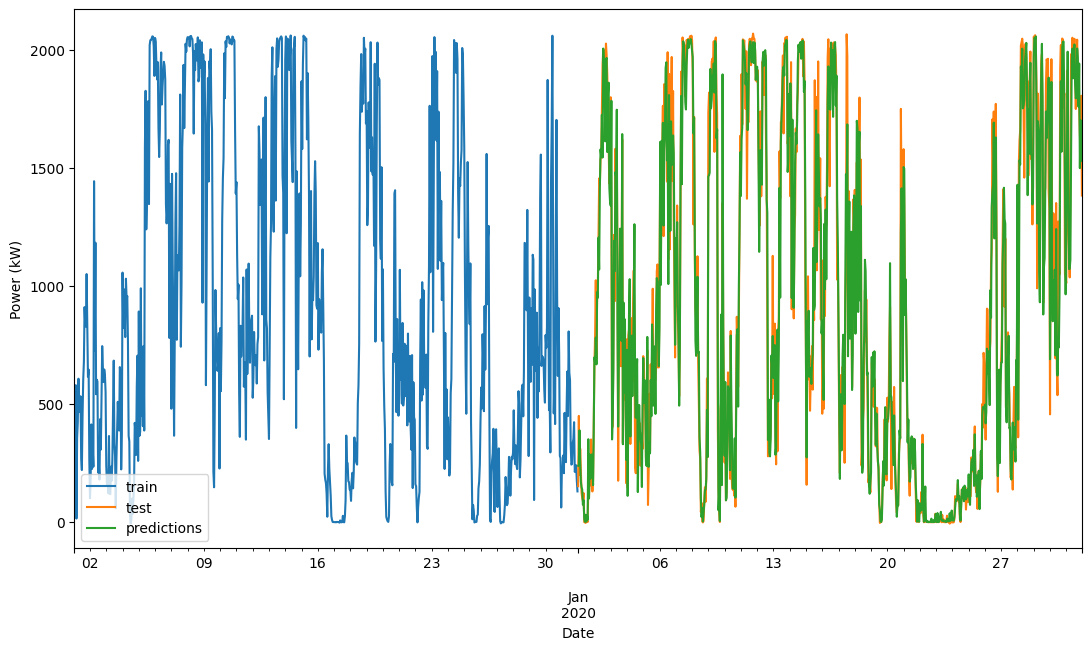

In [483]:
fig, ax = plt.subplots(figsize=(13, 7))
y_train[(y_train.index > "12-01-2019") & (y_train.index <= "12-01-2020")].plot(ax=ax, label="train")
y_test[y_test.index < "02-01-2020"].plot(ax=ax, label="test")
predictions[predictions.index < "02-01-2020"].plot(ax=ax, label="predictions")
ax.set_ylabel("Power (kW)")
ax.legend();

#fig.savefig("one_step.png")

Feature importance for lags increases as they approach the current time. The most important lag, `p_10`, shows that the 10min preceding is by far the most important in determining the power output 10min ahead.

In [484]:
rf.feature_importances_

array([0.00926505, 0.01004249, 0.01043785, 0.01113172, 0.01247342,
       0.94664947])

In [485]:
feature_sort = np.argsort(rf.feature_importances_)
X.columns[feature_sort]

Index(['p_60', 'p_50', 'p_40', 'p_30', 'p_20', 'p_10'], dtype='object')

## Second approach: multi-step (recursive autoregressive) forecasting

The above approach works reasonably well, but it has some drawbacks. Since the model is only trained to predict one step in advance, we only realistically get a 10min ahead forecast. With a multi-step approach, we can use the same data to predict any number of steps into the future. This approach is appropriate because wind power is highly autocorrelated. Specifically, this project uses a recursive autoregressive approach, in which a prediction of timestep $t$ uses the prediction from $t-1$ as an input, and so on in a recursive manner. This is further explained in the package used, [Skforecast](https://joaquinamatrodrigo.github.io/skforecast/0.6.0/user_guides/autoregresive-forecaster.html). Skforecast provides utility methods for forecasting using scikit-learn. The downside of this approach is that it quickly breaks down in longer time horizons, as recursive prediction accumulates error.

The approach compares a Random Forest regressor and a linear regressor (Ridge), each wrapped in a class that provides convenience methods for forecasting. It uses 6 lags, which in this case represent 1 hour of past data in 10min increments.

In [14]:
y = wt["Power"].asfreq("10T")
y_train = y[y.index < "01-01-2020"]
y_test = y[(y.index >= "01-01-2020")]

#### Random Forest

In [487]:
rf = RandomForestRegressor(oob_score=True, random_state=123)

forecaster = ForecasterAutoreg(regressor=rf, lags=6)
            
forecaster.fit(y=y_train)
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(oob_score=True, random_state=123) 
Lags: [1 2 3 4 5 6] 
Transformer for y: None 
Transformer for exog: None 
Window size: 6 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2019-01-01 00:00:00'), Timestamp('2019-12-31 23:50:00')] 
Training index type: DatetimeIndex 
Training index frequency: 10T 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': True, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2022-12-06 19:39:56 
Last fit date: 2022-12-06 19:40:33 
Skforecast version: 0.5.1 
Python version: 3.9.10 

A quick look at a predicting the first hour of the test set shows a promising result with relatively low MAE.

In [488]:
predictions = forecaster.predict(steps=6)
y_true = y_test[:6]

np.mean(abs(y_true - predictions))

85.88497141537182

This model can be more rigorously tested using [backtesting](https://joaquinamatrodrigo.github.io/skforecast/0.6.0/user_guides/backtesting.html), a cross-validation technique suited for time series data (_note: A typical k-folds cross validation technique here would cause data leakage, as some folds will end up incorporating future information into training, which is unrealistic!_). While backtesting without refitting is faster, a refitting backtest with fixed/variable training size would likely be more applicable: in a production system, it may be beneficial to refit the model to capture changing output patterns over time.

This backtest examines the error resulting from a model that predicts 1 hour (6 steps) forward. It does not refit, meaning that it only trains once, then runs against the test data. It outputs the MAE of the predictions against the observed power values.

In [489]:
metric, predictions = backtesting_forecaster(
    forecaster         = forecaster,
    y                  = y,
    initial_train_size = len(y_train),
    fixed_train_size   = False,
    steps              = 6,
    metric             = "mean_absolute_error",
    refit              = False,
    verbose            = False
)

In [490]:
metric

154.91278485835144

In [491]:
# RMSE
mean_squared_error(y_true=y_test, y_pred=predictions, squared=False)

237.51675069133555

In [492]:
forecaster.get_feature_importance()

,feature,importance
0,lag_1,0.946779
1,lag_2,0.011718
2,lag_3,0.011001
3,lag_4,0.010057
4,lag_5,0.010105
5,lag_6,0.010339


A glance at a 2 month slice of the results shows that the model appears to fit well, but underpredicts when large spikes/drops in power occur.

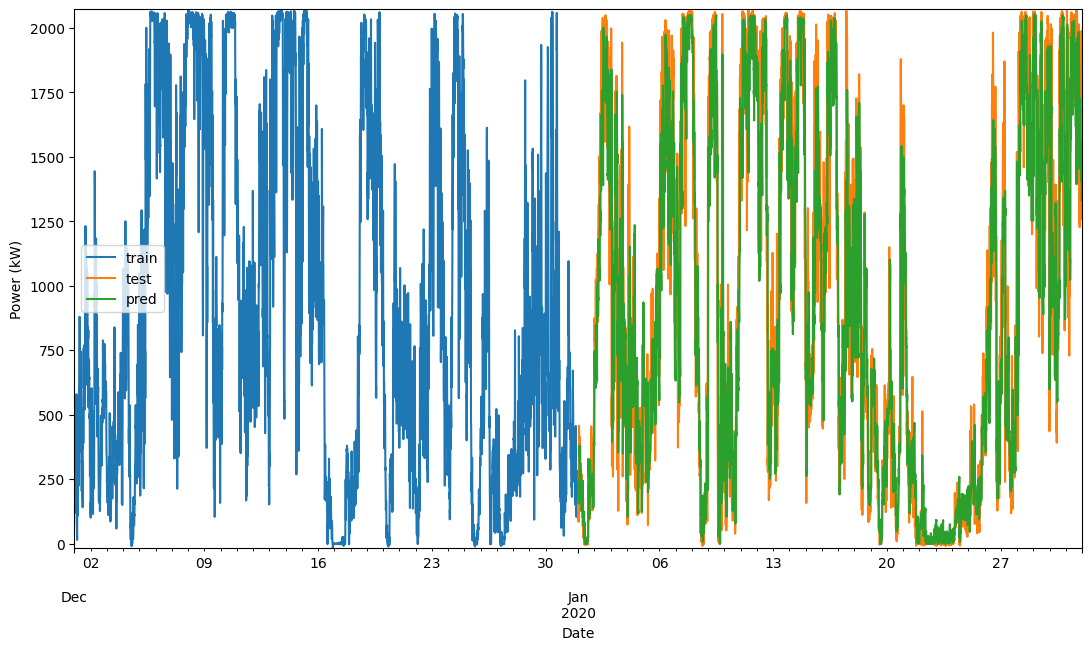

In [493]:
fig, ax = plt.subplots(figsize=(13, 7))
y_train[y_train.index >= "12-01-2019"].plot(ax=ax, label="train")
y_test[y_test.index < "02-01-2020"].plot(ax=ax, label="test")
predictions[predictions.index < "02-01-2020"].plot(ax=ax, label="predictions")
ax.set_ylabel("Power (kW)")
ax.set_ymargin(0)
ax.legend();

#fig.savefig("rf_multi.png")

#### Hyperparameter Tuning

_TODO: This may need to be run on a dedicated server, or the training/testing sets need to be made smaller._

In [494]:
# y_train = y[y.index < "01-01-2020"]
# y_validation = y[(y.index >= "01-01-2020") & (y.index < "06-01-2020")]
# y_test = y[(y.index >= "06-01-2020")]

# rf = RandomForestRegressor(oob_score=True)
# forecaster = ForecasterAutoreg(regressor=rf, lags=6)

# # Lags used as predictors
# lags_grid = [3, 6, 12]

# # Regressor's hyperparameters
# param_grid = {'n_estimators': [100, 300, 500]}

# results_grid = grid_search_forecaster(
#                         forecaster         = forecaster,
#                         y                  = y[:"03-01-2020"],
#                         param_grid         = param_grid,
#                         lags_grid          = lags_grid,
#                         steps              = 6,
#                         refit              = False,
#                         metric             = 'mean_squared_error',
#                         initial_train_size = len(y_train),
#                         fixed_train_size   = False,
#                         return_best        = True,
#                         verbose            = False
#                )

#### Linear (Ridge)

In [64]:
linear_forecaster = ForecasterAutoreg(
    regressor = Ridge(random_state=123),
    lags=6,
    transformer_y = StandardScaler()
)
            
linear_forecaster.fit(y=y_train)
linear_forecaster

ForecasterAutoreg 
Regressor: Ridge(random_state=123) 
Lags: [1 2 3 4 5 6] 
Transformer for y: StandardScaler() 
Transformer for exog: None 
Window size: 6 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2019-01-01 00:00:00'), Timestamp('2019-12-31 23:50:00')] 
Training index type: DatetimeIndex 
Training index frequency: 10T 
Regressor parameters: {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': 'deprecated', 'positive': False, 'random_state': 123, 'solver': 'auto', 'tol': 0.001} 
Creation date: 2022-12-18 14:12:37 
Last fit date: 2022-12-18 14:12:37 
Skforecast version: 0.6.0 
Python version: 3.9.16 

In [65]:
metric, predictions = backtesting_forecaster(
    forecaster         = linear_forecaster,
    y                  = y,
    initial_train_size = len(y_train),
    fixed_train_size   = False,
    steps              = 6,
    metric             = "mean_absolute_error",
    refit              = False,
    verbose            = False
)

These results show that it matches, if not outperforms, the same approach using the RF regressor. It is possible that this data follows a pattern matching the more classical definition of autoregressive models, in that power output depends linearly on its past values. With this knowledge, it would be interesting to see how this approach compares to models like ARIMA in terms of performance. 

In [66]:
metric

151.64748833537143

In [67]:
mean_squared_error(y_true=y_test, y_pred=predictions, squared=False)

230.631662087883

The feature importance looks similar here, with the first lag being by far the most important. It is not quite as strong as it is in the RF regressor, however.

In [112]:
linear_forecaster.get_feature_importance()

,feature,importance
0,lag_1,0.849002
1,lag_2,0.004633
2,lag_3,0.040468
3,lag_4,0.027478
4,lag_5,0.014571
5,lag_6,0.041885
